In [1]:
%set_env GOOGLE_APPLICATION_CREDENTIALS=C:\Users\Mark\Desktop\PurdueEats-e85c448de7a4.json

env: GOOGLE_APPLICATION_CREDENTIALS=C:\Users\Mark\Desktop\PurdueEats-e85c448de7a4.json


In [2]:
from google.cloud import bigquery
import sys
from backend.DB.Util import runQuery
from backend.API.routes.menu import get_nutrition, nutrition_to_macros, get_menu_item
import pandas as pd
import datetime

gcp_project = "purdueeats-304919"
bq_dataset = "PurdueEatsDatabase"

client = bigquery.Client(project=gcp_project)
dataset_ref = client.dataset(bq_dataset)

def userReviewsSummary(UserID):
    reviews = runQuery( f"select user.UserID, MenuItemID, Rating, Timestamp from UserBasic as user Inner Join MenuItemsReviews as txn on user.UserID = txn.UserID WHERE user.UserID = {UserID}")
    return reviews.to_dataframe()

def allTransactionsSummary():
    transactions = runQuery( f"select UserID, TransactionAmount, Balance, Timestamp from  UserTransaction ")
    return transactions.to_dataframe()


def getMenuItemName(MenuItemID):
    rtn = runQuery( f"select ItemName from MenuItems WHERE MenuItemID = {MenuItemID}").to_dataframe()
    rtn.columns = [''] * len(rtn.columns)
    return rtn

def getMenuItemDetails():
    res = [dict(row) for row in runQuery(
        f"select MenuItemID, ItemName, HashID from MenuItems")]

    rtn = dict()
    xtn = dict()

    for x in res:
        rtn[x['MenuItemID']] = x['ItemName']
        xtn[x['MenuItemID']] = x['HashID']
    
    return rtn, xtn

df = userReviewsSummary(7023699889393535879) #use 7023699889393535879 for example
df['first_day_of_week'] = df["Timestamp"].apply(lambda df:
                                        datetime.datetime(year=df.year, month=df.month, day=df.day))
df.set_index(df["first_day_of_week"], inplace=True) #makes lines 56-59 run

calories = [] #these empty lists will be populated with in the for loop below, then added as columns to dataset.
carbs = []
fat = []
protein = []
menuItemStr = []

for i, row in df.iterrows():
    menu_item_id = row[1] #this is the menu item id
    menuItemStr.append(getMenuItemName(menu_item_id).loc[0].to_string()[4:])
    response = get_nutrition(menu_item_id)
    _calories, _carbs, _fat, _protein = nutrition_to_macros(response)
    calories.append(_calories)
    carbs.append(_carbs)
    fat.append(_fat)
    protein.append(_protein)
df['calories'] = calories
df['carbs'] = carbs
df['fat'] = fat
df['protein'] = protein
df['menuItemStr'] = menuItemStr

weekly_avg_calories = df.calories.resample('W').sum() / df.first_day_of_week.resample('W').count()
weekly_avg_carbs = df.carbs.resample('W').sum() / df.first_day_of_week.resample('W').count()
weekly_avg_fat = df.fat.resample('W').sum() / df.first_day_of_week.resample('W').count()
weekly_avg_protein = df.protein.resample('W').sum() / df.first_day_of_week.resample('W').count()
#sum of total calories per week / number of active input days per week

#counting unique occurences
df['menuItemStr'] = df['menuItemStr'].str.split()
menu_item_count = df['menuItemStr'].apply(pd.Series).stack().reset_index(drop=True).value_counts()
#menu_item_count = df['MenuItemID'].value_counts() #obsolete line that returns menu item id with count

# this is to calculate user transactions
df2 = userTransactionsSummary(7023699889393535879)
df2['first_day_of_week'] = df2["Timestamp"].apply(lambda df2:
                                        datetime.datetime(year=df2.year, month=df2.month, day=df2.day))
df2.set_index(df2["first_day_of_week"], inplace=True) #makes line 74 run
weekly_summary_trans = df2.TransactionAmount.resample('W').sum()

print("\nMenu Item Count is used for word cloud. It contains the menu item # followed by the count.")
print(f"\nmenu_item_count: \n{menu_item_count}") #frequency count of menu items; for word cloud

print("\nWeekly macro averages are below. They're in Series format and can thus be plotted. The index is the first day of the week, the values are average macro consumed of that week")
print(f"\nweekly_avg_calories: \n{weekly_avg_calories}") #this is a series
print(f"\nweekly_avg_carbs: \n{weekly_avg_carbs}")  # this is a series
print(f"\nweekly_avg_fat: \n{weekly_avg_fat}") #this is a series
print(f"\nweekly_avg_protein: \n{weekly_avg_protein}") #this is a series
print("\nWeekly sum transactions averages are below. They're in the same format as above.")
print(f"\nweekly_summary_trans \n{weekly_summary_trans}") #this is a series.


In [3]:
def mealPlanSummary():
    mealPlans = runQuery( f"SELECT * FROM UserExtra")
    return mealPlans.to_dataframe()
    

In [4]:
mealPlansDF = mealPlanSummary()
mealPlansDF

,UserID,MealPlanName,MealSwipeCount,DiningDollarBalance
0,2810710999154368828,21 Meal Plan +250,21,250.00
1,6967645914836607210,10 Meal Plan +100,10,100.00
2,-8325608802771069211,10 Meal Plan +100,10,100.00
3,8882272202218536392,10 Meal Plan +100,10,100.00
4,-644379582692266724,15 Meal Plan +450,15,405.00
5,4087605085059207658,15 Meal Plan +450,15,420.00
6,8788104928683024331,15 Meal Plan +450,15,450.00
7,1589774858082006536,15 Meal Plan +450,15,950.00
8,4467606805034911759,15 Meal Plan +450,15,450.00
9,7023699889393535879,15 Meal Plan +450,15,108.34


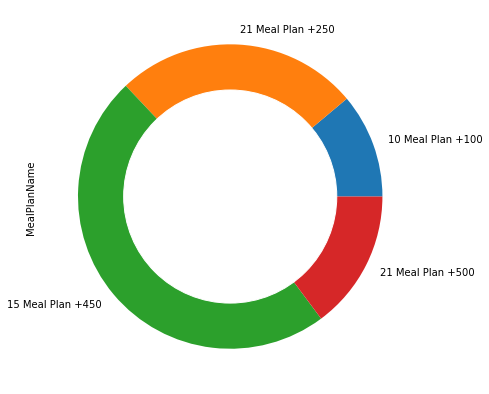

In [5]:
import matplotlib.pyplot as plt
mealPlansDF.MealPlanName.value_counts(sort=False).plot.pie(figsize = (7,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [6]:
def getAllUsers():
    allUsers = runQuery(f"SELECT UserID FROM UserBasic")
    return allUsers.to_dataframe()
allUserID = getAllUsers()

In [7]:
#WARNING: RUNTIME IS LIKE A MINUTE NOW
#get all the menu items all users have consumed
rtn, xtn = getMenuItemDetails()

masterList = []

for UserID in allUserID.UserID.tolist():
    print(UserID)
    df = userReviewsSummary(UserID) #use 7023699889393535879 for example
    
    def get_value(keyy, my_dict):
        for key, value in my_dict.items():
            if key == keyy:
                return value
 
        return "key doesn't exist"

    df.MenuItemID = df.MenuItemID.apply(lambda x: get_value(x, rtn))
    df.MenuItemID = df.MenuItemID.astype(str)
    #print(df.MenuItemID)
    #display(df.dtypes)
    menuItemStr =df.MenuItemID.to_list()
    
    
    #counting unique occurences
    if not menuItemStr: #if the list is empty:
        print("User has made no reviews!")
    else:
        df['MenuItemID'] = df['MenuItemID'].str.split()
        masterList.append(df['MenuItemID'].apply(pd.Series).stack().reset_index(drop=True))
masterList

-4903962852921021689
-2242890609849612160
-9001107976745399192
-8488187732628473157
3028983648645194487
737319298931306801
-1619648933082824640
User has made no reviews!
4087605085059207658
8868460133119895895
User has made no reviews!
-2589269694930711347
6295342170354506735
6967645914836607210
8788104928683024331
1589774858082006536
4467606805034911759
-1671267070407422883
8882272202218536392
User has made no reviews!
-644379582692266724
2095955503326350370
7023699889393535879
-2950671479005323586
-6972977857218552086
-4518613502442612524
0
-7051850150604121449
3183534950451599476
User has made no reviews!
-5179890033796933917
User has made no reviews!
8099793272915706690
-8325608802771069211
-7967665590231560711
User has made no reviews!
-786297260319589266
User has made no reviews!
2810710999154368828


[0        Plain
 1        Bagel
 2        Fresh
 3     Broccoli
 4      Florets
 5      Roasted
 6     Seasoned
 7     Broccoli
 8         Mini
 9       Spring
 10       Rolls
 dtype: object,
 0          Green
 1          Beans
 2           Beef
 3          Gravy
 4       Homemade
          ...    
 150         Eggs
 151    Scrambled
 152         With
 153      Cheddar
 154       Cheese
 Length: 155, dtype: object,
 0          Peach
 1         Slices
 2           Mozz
 3          Style
 4       Shredded
 5          Vegan
 6         Cheese
 7          Cajun
 8        Grilled
 9        Chicken
 10        Breast
 11       BoilerQ
 12           BBQ
 13       Chicken
 14     Drumstick
 15         Pesto
 16    Tortellini
 17      Shredded
 18       Lettuce
 19          Oreo
 20        Cookie
 21       Blondie
 22       Brownie
 23         Fried
 24      Potatoes
 25       Roasted
 26        Garlic
 27        Butter
 28       Carrots
 dtype: object,
 0     Quesadilla
 1        Toppers
 2     

In [8]:
flatList = [ item for elem in masterList for item in elem] #turn list of lists into single list
d = {x:flatList.count(x) for x in flatList}

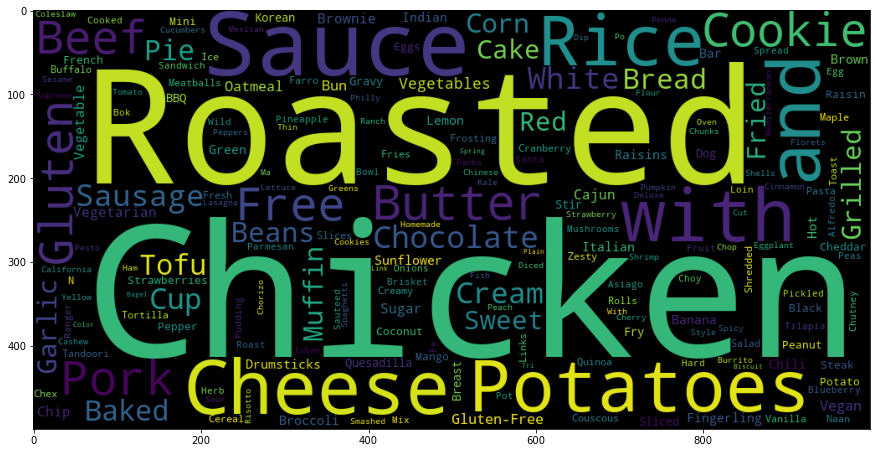

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

In [10]:
#do all user transactions trends, user transactions trends per meal plan

In [11]:
transactions = allTransactionsSummary()

In [18]:
transactions = transactions.sort_values(by=['Timestamp']) #sort df by time
transactions = transactions[transactions.UserID != 0] #get rid of userid 0 since that's admin
transactions = transactions[transactions.UserID != -2950671479005323586] #get rid of this weird transactoin that's -1000
transactions = transactions[transactions.UserID != -7051850150604121449] #same with t his guyS
transactions = transactions.drop(2)
transactions

,UserID,TransactionAmount,Balance,Timestamp
31,2810710999154368828,1.00,79.00,2021-01-22 20:19:47.599000+00:00
30,2810710999154368828,3.00,76.00,2021-01-30 20:19:47.599000+00:00
26,-786297260319589266,10.00,340.00,2021-01-30 20:19:47.599000+00:00
34,2810710999154368828,10.00,66.00,2021-02-05 20:19:47.599000+00:00
33,2810710999154368828,15.00,51.00,2021-02-10 20:19:47.599000+00:00
23,-786297260319589266,10.00,350.00,2021-02-10 20:19:47.599000+00:00
29,2810710999154368828,20.00,31.00,2021-02-20 20:19:47.599000+00:00
35,2810710999154368828,28.00,3.00,2021-03-01 20:19:47.599000+00:00
32,2810710999154368828,24.00,-21.00,2021-03-06 20:19:47.599000+00:00
25,-786297260319589266,30.00,380.00,2021-03-10 20:19:47.599000+00:00


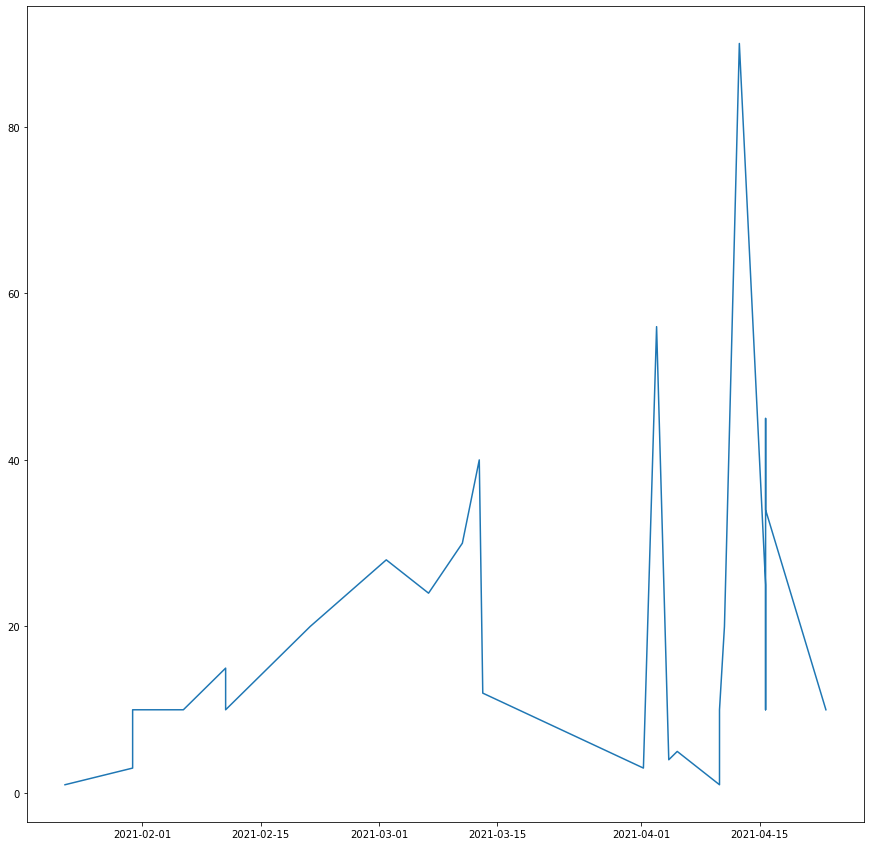

In [19]:
plt.figure(figsize=(15, 15))
plt.plot(transactions.Timestamp,transactions.TransactionAmount)

In [20]:
merged = pd.merge(mealPlansDF, transactions, on="UserID", how='outer')

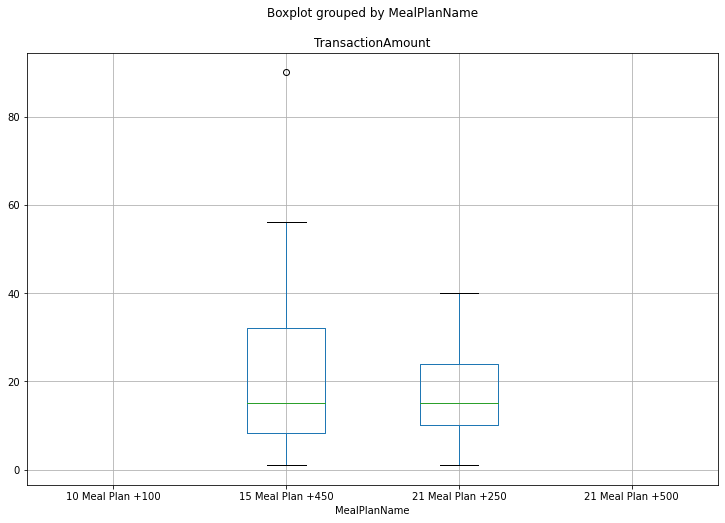

In [21]:
bp = merged.boxplot(by='MealPlanName', column=['TransactionAmount'], figsize=(12,8))